In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [2]:
our_data = pd.read_csv('filtered_df.csv')

In [3]:
data = our_data[['CDNA_POSITION', 'MUTATION_EVENT', 'BASE_ALLELE', 'MUTANT_ALLELE', 'MUTATION_AA', 'WT_AA_1', 'WT_AA_3',
               'CODON_POSITION', 'MT_AA_1', 'MT_AA_3', 'MUTATION_SOMATIC_STATUS', 'PRIMARY_SITE', 'SAMPLE_TYPE',
               'TUMOUR_ORIGIN', 'CANCER_TYPE']]
data

,CDNA_POSITION,MUTATION_EVENT,BASE_ALLELE,MUTANT_ALLELE,MUTATION_AA,WT_AA_1,WT_AA_3,CODON_POSITION,MT_AA_1,MT_AA_3,MUTATION_SOMATIC_STATUS,PRIMARY_SITE,SAMPLE_TYPE,TUMOUR_ORIGIN,CANCER_TYPE
0,249,C>A,C,A,p.H83Q,H,His,83,Q,Gln,Variant of unknown origin,pleura,surgery fresh/frozen,primary,Other
1,188,T>C,T,C,p.L63P,L,Leu,63,P,Pro,Variant of unknown origin,skin,surgery - NOS,metastasis,Skin Cancer
2,224,C>T,C,T,p.P75L,P,Pro,75,L,Leu,Variant of unknown origin,lung,surgery-fixed,metastasis,Carcinoma
3,86,G>A,G,A,p.R29Q,R,Arg,29,Q,Gln,Variant of unknown origin,upper aerodigestive tract,surgery-fixed,NS,Carcinoma
4,156,G>C,G,C,p.M52I,M,Met,52,I,Ile,Variant of unknown origin,breast,cell-line,NS,Carcinoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,242,C>T,C,T,p.P81L,P,Pro,81,L,Leu,Confirmed somatic variant,skin,surgery-fixed,metastasis,Skin Cancer
1347,250,G>A,G,A,p.D84N,D,Asp,84,N,Asn,Confirmed somatic variant,central nervous system,NS,NS,Brain Tumor
1348,367,C>A,C,A,p.H123N,H,His,123,N,Asn,Confirmed somatic variant,lung,surgery-fixed,primary,Carcinoma
1349,251,A>G,A,G,p.D84G,D,Asp,84,G,Gly,Confirmed somatic variant,central nervous system,surgery fresh/frozen,NS,Brain Tumor


In [4]:
numeric_features = data.select_dtypes(include=[np.number])
print(numeric_features.columns)
print(len(numeric_features.columns))

Index(['CDNA_POSITION', 'CODON_POSITION'], dtype='object')
2


In [5]:
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['MUTATION_EVENT', 'BASE_ALLELE', 'MUTANT_ALLELE', 'MUTATION_AA',
       'WT_AA_1', 'WT_AA_3', 'MT_AA_1', 'MT_AA_3', 'MUTATION_SOMATIC_STATUS',
       'PRIMARY_SITE', 'SAMPLE_TYPE', 'TUMOUR_ORIGIN', 'CANCER_TYPE'],
      dtype='object')


In [6]:
missing_values = data.isnull().sum()
print(missing_values)

CDNA_POSITION              0
MUTATION_EVENT             0
BASE_ALLELE                0
MUTANT_ALLELE              0
MUTATION_AA                0
WT_AA_1                    0
WT_AA_3                    0
CODON_POSITION             0
MT_AA_1                    0
MT_AA_3                    0
MUTATION_SOMATIC_STATUS    0
PRIMARY_SITE               0
SAMPLE_TYPE                0
TUMOUR_ORIGIN              0
CANCER_TYPE                0
dtype: int64


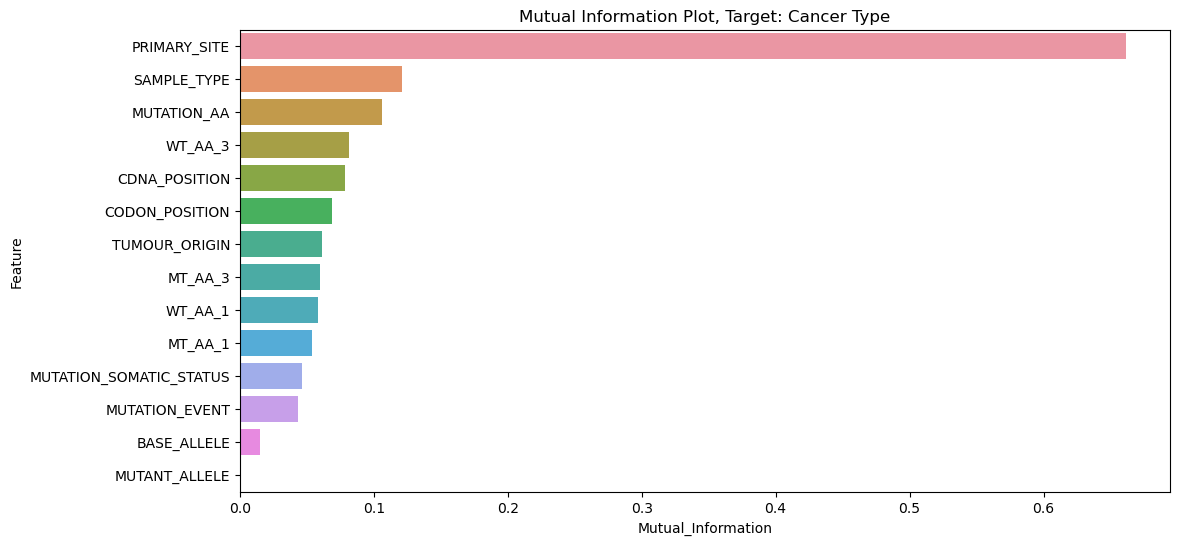

In [7]:
label_encoder = LabelEncoder()

dat = data.copy()

categorical_columns = dat.select_dtypes(include='object').columns
dat[categorical_columns] = dat[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

dat['CANCER_TYPE'] = label_encoder.fit_transform(dat['CANCER_TYPE'])

mutual_info = mutual_info_classif(dat.drop('CANCER_TYPE', axis=1), dat['CANCER_TYPE'])
mi_df = pd.DataFrame({'Feature': dat.columns[:-1], 'Mutual_Information': mutual_info})

plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual_Information', y='Feature', data=mi_df.sort_values(by='Mutual_Information', ascending=False))
plt.title('Mutual Information Plot, Target: Cancer Type')
plt.show()

## Predictive Modeling: K-means Clustering

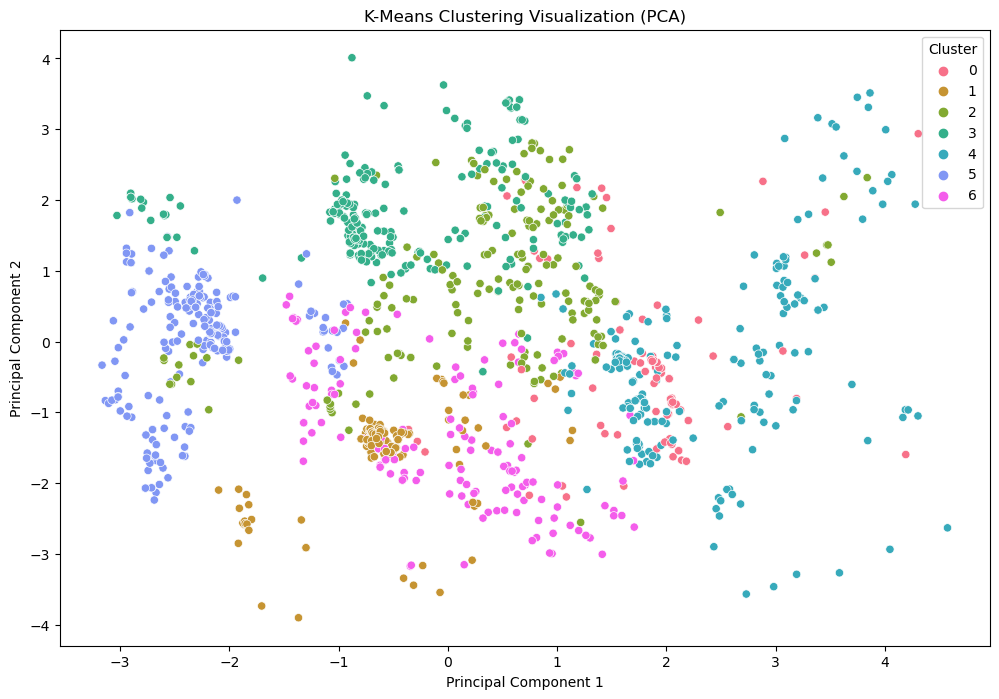

In [8]:
data = data.copy()

# Extract relevant features
numerical_columns = ['CDNA_POSITION', 'CODON_POSITION']
categorical_columns = ['MUTATION_EVENT', 'BASE_ALLELE', 'MUTANT_ALLELE', 'MUTATION_AA',
                        'WT_AA_1', 'WT_AA_3', 'MT_AA_1', 'MT_AA_3', 'MUTATION_SOMATIC_STATUS',
                        'PRIMARY_SITE', 'SAMPLE_TYPE', 'TUMOUR_ORIGIN', 'CANCER_TYPE']

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Combine numerical and encoded categorical columns
X = pd.concat([data[numerical_columns], data[categorical_columns]], axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of clusters (number of cancer types)
k = 7
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
df_visualize = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_visualize['Cluster'] = data['Cluster']

# Define a list of colors for each cluster
cluster_colors = sns.color_palette('husl', n_colors=k)

# Plot the clusters with separate colors
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_visualize, palette=cluster_colors, legend='full')
plt.title('K-Means Clustering Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

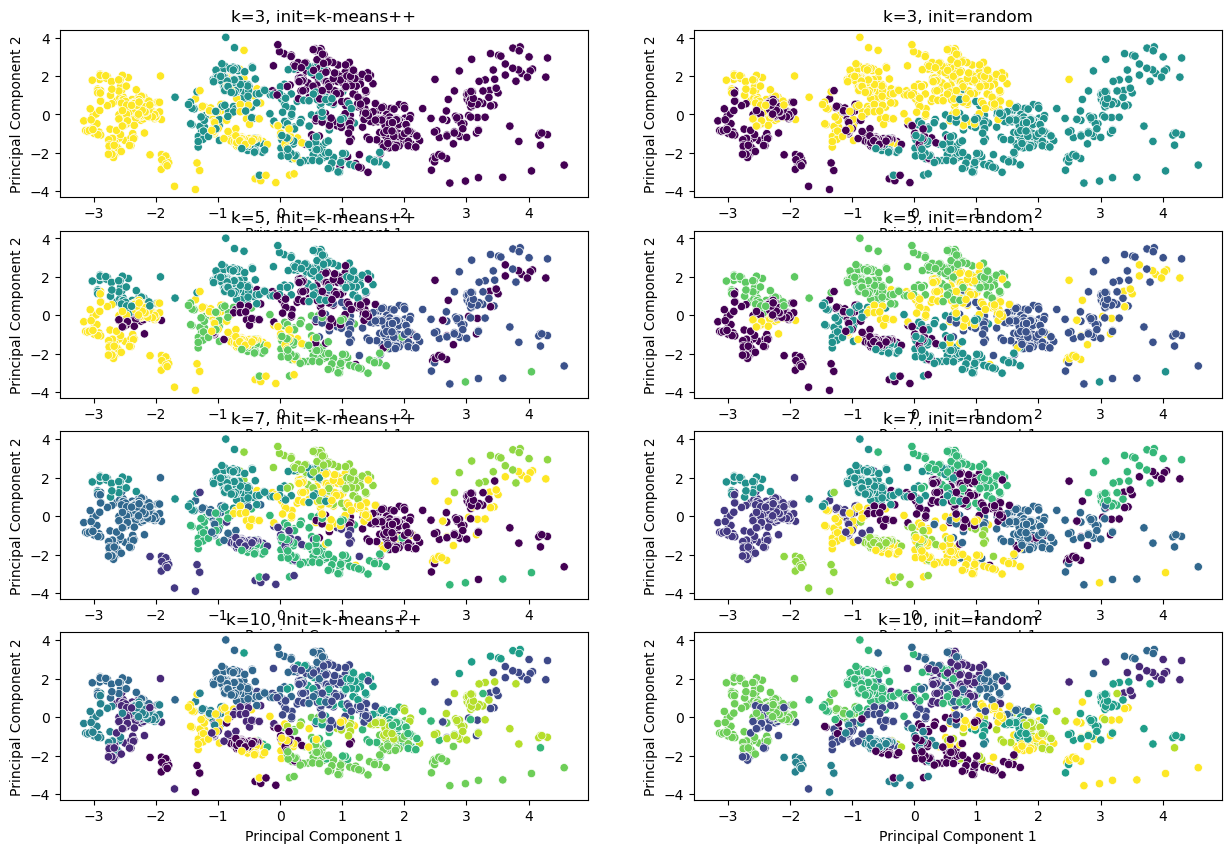

In [9]:
data = data.copy()

# Extract relevant features
numerical_columns = ['CDNA_POSITION', 'CODON_POSITION']
categorical_columns = ['MUTATION_EVENT', 'BASE_ALLELE', 'MUTANT_ALLELE', 'MUTATION_AA',
                        'WT_AA_1', 'WT_AA_3', 'MT_AA_1', 'MT_AA_3', 'MUTATION_SOMATIC_STATUS',
                        'PRIMARY_SITE', 'SAMPLE_TYPE', 'TUMOUR_ORIGIN', 'CANCER_TYPE']

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Combine numerical and encoded categorical columns
X = pd.concat([data[numerical_columns], data[categorical_columns]], axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# different values of k and initialization methods
k_values = [3, 5, 7, 10]  
init_methods = ['k-means++', 'random']  

# Visualize using PCA
plt.figure(figsize=(15, 10))
for k in k_values:
    for init_method in init_methods:
        kmeans = KMeans(n_clusters=k, random_state=42, init=init_method, n_init=23)
        data['Cluster'] = kmeans.fit_predict(X_scaled)

        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        df_visualize = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_visualize['Cluster'] = data['Cluster']

        plt.subplot(len(k_values), len(init_methods), k_values.index(k) * len(init_methods) + init_methods.index(init_method) + 1)
        sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_visualize, palette='viridis', legend=False)
        plt.title(f'k={k}, init={init_method}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

plt.show()

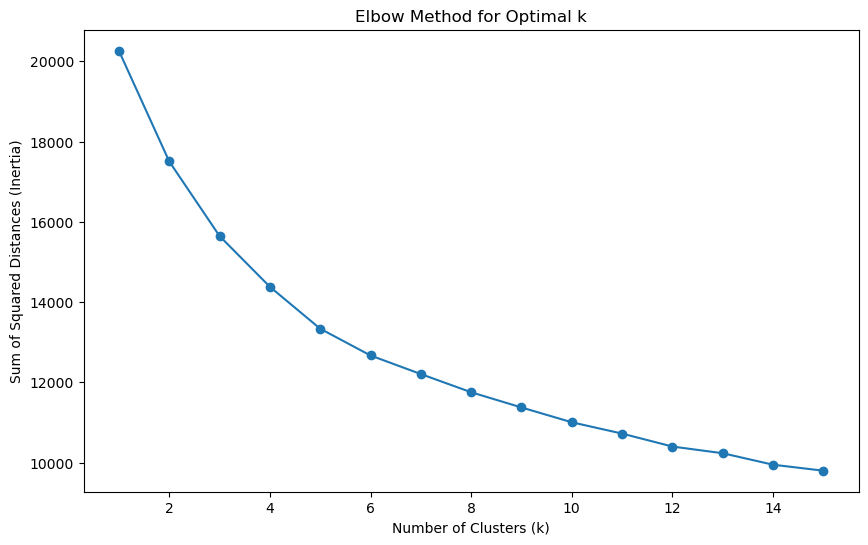

In [10]:
data = data.copy()

# Extract relevant features
numerical_columns = ['CDNA_POSITION', 'CODON_POSITION']
categorical_columns = ['MUTATION_EVENT', 'BASE_ALLELE', 'MUTANT_ALLELE', 'MUTATION_AA',
                        'WT_AA_1', 'WT_AA_3', 'MT_AA_1', 'MT_AA_3', 'MUTATION_SOMATIC_STATUS',
                        'PRIMARY_SITE', 'SAMPLE_TYPE', 'TUMOUR_ORIGIN', 'CANCER_TYPE']

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Combine numerical and encoded categorical columns
X = pd.concat([data[numerical_columns], data[categorical_columns]], axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run k-means for different values of k and collect inertias
inertias = []
k_values = range(1, 16) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()

In [11]:
data = data.copy()

# Extract relevant features
numerical_columns = ['CDNA_POSITION', 'CODON_POSITION']
categorical_columns = ['MUTATION_EVENT', 'BASE_ALLELE', 'MUTANT_ALLELE', 'MUTATION_AA',
                        'WT_AA_1', 'WT_AA_3', 'MT_AA_1', 'MT_AA_3', 'MUTATION_SOMATIC_STATUS',
                        'PRIMARY_SITE', 'SAMPLE_TYPE', 'TUMOUR_ORIGIN', 'CANCER_TYPE']

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Combine numerical and encoded categorical columns
X = pd.concat([data[numerical_columns], data[categorical_columns]], axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run k-means clustering with your chosen parameters
k = 7
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Evaluate clustering performance
ari = adjusted_rand_score(data['CANCER_TYPE'], data['Cluster'])
silhouette_avg = silhouette_score(X_scaled, data['Cluster'])

print(f"Adjusted Rand Index: {ari}")
print(f"Silhouette Score: {silhouette_avg}")

Adjusted Rand Index: 0.05504803139599864
Silhouette Score: 0.1375302277714877


## XGBoost

In [12]:
data_copy = data.copy()

# Encode categorical columns
label_encoder = LabelEncoder()
label_encoder_cancer_type = LabelEncoder()

# Store the mapping between original cancer types and encoded labels
cancer_type_mapping = dict(zip(data_copy['CANCER_TYPE'], label_encoder_cancer_type.fit_transform(data_copy['CANCER_TYPE'])))

# Apply label encoding to the 'CANCER_TYPE' column
data['CANCER_TYPE'] = label_encoder_cancer_type.transform(data['CANCER_TYPE'])

# Split the data into features (X) and target variable (y)
X = data.drop('CANCER_TYPE', axis=1)
y = data['CANCER_TYPE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

Accuracy: 0.9188191881918819
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.94      0.98      0.96       191
           2       0.67      0.57      0.62         7
           3       0.40      0.50      0.44         4
           4       0.83      0.36      0.50        14
           5       0.50      0.50      0.50         2
           6       0.95      0.93      0.94        43

    accuracy                           0.92       271
   macro avg       0.76      0.68      0.70       271
weighted avg       0.92      0.92      0.91       271

